<a href="https://colab.research.google.com/github/241854/ML.Industry-4.0/blob/main/%20code_Industry%204.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***1) descrizione dei dati***

Poiché i set di dati sulla manutenzione predittiva reale sono generalmente difficili da ottenere e in particolare difficili da pubblicare, i dati forniti dal repository UCI sono un insieme di dati sintetico che riflette la reale manutenzione predittiva riscontrata nell'industria al meglio delle loro conoscenze. Il set di dati è costituito da 10.000 punti dati memorizzati come righe con 14 caratteristiche nelle colonne: punto per una delle seguenti modalità di guasto sono vere.

IDI: identificatore unico compreso tra 1 e 10000;
ID prodotto: costituito da una lettera L, M, o H per bassa (60% di tutti i prodotti), medio (30%) e alto (10%) come varianti di qualità del prodotto e un numero di serie variante-specifica;
Temperatura dell'aria [K]: generata utilizzando un processo di camminata casuale successivamente normalizzato a una deviazione standard di 2 K circa 300 K;
Temperatura di processo [K]: generata utilizzando un processo di camminata casuale normalizzato a una deviazione standard di 1 K, aggiunta alla temperatura dell'aria più 10 K;
velocità di rotazione [rpm]: calcolata da una potenza di 2860 W, sovrapposta a un rumore normalmente distribuito;
coppia [Nm]: i valori di coppia sono normalmente distribuiti intorno a 40 Nm con una deviazione standard di 10 Nm e senza valori negativi;
Usura utensile [min]: le varianti di qualità H/M/L aggiungono 5/3/2 minuti di usura utensile all'utensile utilizzato nel processo;
Guasto della macchina: etichetta che indica se la macchina non è riuscita in questo particolare dato
Il guasto della macchina è costituito da cinque modalità di guasto indipendenti: la variante del prodotto L (12.000 M, 13.000 H), il processo non riesce a causa di overstrain;

guasto dell'utensile (TWF): l'utensile verrà sostituito da guasto in un tempo di usura dell'utensile selezionato casualmente tra 200 - 240 minuti;

guasto di dissipazione del calore (HDF): la dissipazione del calore causa un guasto del processo, se la differenza tra la temperatura dell'aria e quella di processo è inferiore a 8,6 K e la velocità di rotazione degli utensili è inferiore a 1380 rpm;

mancanza di potenza (PWF): il prodotto della coppia e della velocità di rotazione (in rad/s) è uguale alla potenza richiesta per il processo. Se questa potenza è inferiore a 3500 W o superiore a 9000 W, il processo non riesce;
avaria di sovraccarico (OSF): se il prodotto di usura e coppia degli utensili supera 11.000 minNm per

guasti casuali (RNF): ogni processo ha una probabilità dello 0,1 % di fallire indipendentemente dai suoi parametri di processo. Se almeno una delle modalità di guasto di cui sopra è vera, il processo fallisce e l'etichetta 'guasto macchina' è impostata su 1. Non è quindi trasparente al metodo di apprendimento automatico, quale delle modalità di guasto ha causato il fallimento del processo

2) **Analisi esplorativa**

La nostra esplorazione dei dati inizia controllando che ogni voce è unica e non ci sono duplicati; questo viene fatto dalla verificazione che ci sia solo un  numero unico ProductID che corrisponde al numero di osservazioni. Quindi stampiamo un rapporto per cercare i valori mancanti e controllare il tipo di dati per ogni colonna.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import data
data = pd.read_csv("/content/predictive_maintenance.csv")
n = data.shape[0]
# First checks
print('Features non-null values and data type:')
data.info()
print('Check for duplicate values:',
      data['Product ID'].unique().shape[0]!=n)

Features non-null values and data type:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
Check for duplicate values: False


In [2]:
# Set numeric columns dtype to float
data['Tool wear [min]'] = data['Tool wear [min]'].astype('float64')
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].astype('float64')
# Rename features
data.rename(mapper={'Air temperature [K]': 'Air temperature',
                    'Process temperature [K]': 'Process temperature',
                    'Rotational speed [rpm]': 'Rotational speed',
                    'Torque [Nm]': 'Torque',
                    'Tool wear [min]': 'Tool wear'}, axis=1, inplace=True)

2.1) Colonne di identificazione


Prima di entrare in questioni più tecniche ci occupiamo delle due colonne ID come il modello che useremo potrebbe confondersi da loro, dal momento che non è realistico pensare che il fallimento di una macchina dipende dal suo identificatore. Tuttavia, mentre l'UDI risulta essere una copia dell'indice del dataframe, la colonna Product ID è costituita da una lettera iniziale seguita da cinque numeri; c'è una piccola probabilità che dietro questa struttura ci sia un modello nascosto. Tuttavia, la lettera iniziale corrisponde al tipo di macchina e le sequenze numeriche definiscono tre intervalli in base alla stessa caratteristica; ciò consente di confermare che la colonna ID prodotto non contiene più informazioni del tipo di funzione ed è legittimo eliminarla. Il seguente istogramma mostra le sequenze di numeri:

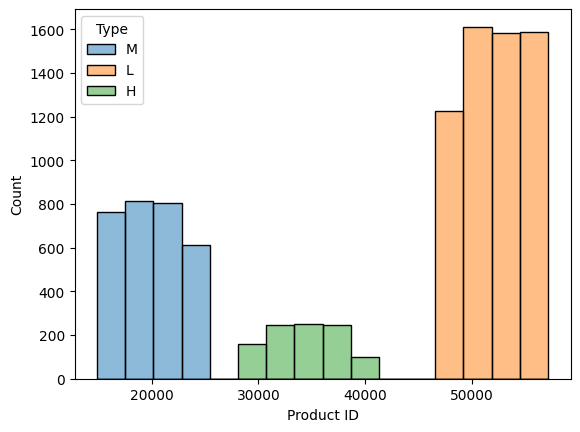

In [3]:
# Remove first character and set to numeric dtype
data['Product ID'] = data['Product ID'].apply(lambda x: x[1:])
data['Product ID'] = pd.to_numeric(data['Product ID'])

# Histogram of ProductID
sns.histplot(data=data, x='Product ID', hue='Type')
plt.show()

In [4]:
# eliminare la col ID
df = data.copy()
df.drop(columns=['UDI','Product ID'], inplace=True)

Il seguente grafico a torta mostra le percentuali delle macchine per tipo:

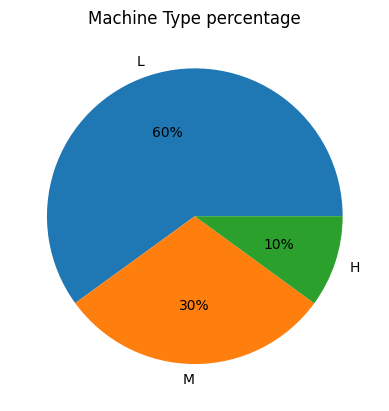

In [5]:
# Grafico a torta della percentuale di tipo
value = data['Type'].value_counts()
Type_percentage = 100*value/data.Type.shape[0]
labels = Type_percentage.index.array
x = Type_percentage.array
plt.pie(x, labels = labels, colors=sns.color_palette('tab10')[0:3], autopct='%.0f%%')
plt.title('Machine Type percentage')
plt.show()

2.2)target(anormalie)
In questa sezione osserviamo la distribuzione del target per individuare eventuali squilibri e correggerli prima di dividere il set di dati. La prima anomalia rispetto alla descrizione del dataset è che quando l'errore è casuale (RNF), la funzione Machine Failure non è impostata su 1.

In [6]:
# Create lists of features and target names
features = [col for col in df.columns
            if df[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']
# Portion of data where RNF=1
idx_RNF = df.loc[df['Failure Type']=='Random Failures'].index
df.loc[idx_RNF,target]

,Target,Failure Type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


Fortunatamente il guasto macchina RNF si verifica in soli 18 osservazioni e ha una natura casuale quindi non prevedibile quindi decidiamo di rimuovere queste righe.

In [7]:
first_drop = df.loc[idx_RNF,target].shape[0]
print('Number of observations where RNF=1 but Machine failure=0:',first_drop)
# Drop corresponding observations and RNF column
df.drop(index=idx_RNF, inplace=True)

Number of observations where RNF=1 but Machine failure=0: 18


Andando avanti scopriamo che in 9 osservazioni il guasto della macchina è impostato su 1 quando tutti i tipi di guasti sono impostati su 0. Non possiamo capire se c'è stato davvero un guasto o meno, quindi rimuoviamo anche queste osservazioni.

In [8]:

# Portion of data where Machine failure=1 but no failure cause is specified
idx_ambiguous = df.loc[(df['Target']==1) &
                       (df['Failure Type']=='No Failure')].index
second_drop = df.loc[idx_ambiguous].shape[0]
print('Number of ambiguous observations:', second_drop)
display(df.loc[idx_ambiguous,target])
df.drop(index=idx_ambiguous, inplace=True)

Number of ambiguous observations: 9


,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


In [9]:
# Global percentage of removed observations
print('Global percentage of removed observations:',
     (100*(first_drop+second_drop)/n))
df.reset_index(drop=True, inplace=True)   # Reset index
n = df.shape[0]

Global percentage of removed observations: 0.27


Le nostre azioni non hanno alterato molto i dati originali.

2.3) Controllo dei valori anomali

L'obiettivo di questa sezione è quello di verificare se il set di dati contiene outlier, che di solito sono fuorvianti per gli algoritmi di machine learning. Iniziamo guardando un rapporto statistico delle caratteristiche numeriche.

In [10]:
df.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
count,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,300.003259,310.004031,1538.893212,39.978993,107.921087,0.033089
std,2.000548,1.483692,179.412171,9.966805,63.649152,0.178879
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.700000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


Possiamo indovinare la presenza di valori anomali in Velocità di rotazione e Coppia perché il massimo è molto diverso dal terzo quartile. Per rendere questa considerazione più concreta diamo uno sguardo più da vicino alla situazione con boxplot, utilizzando gli istogrammi per capire la distribuzione.

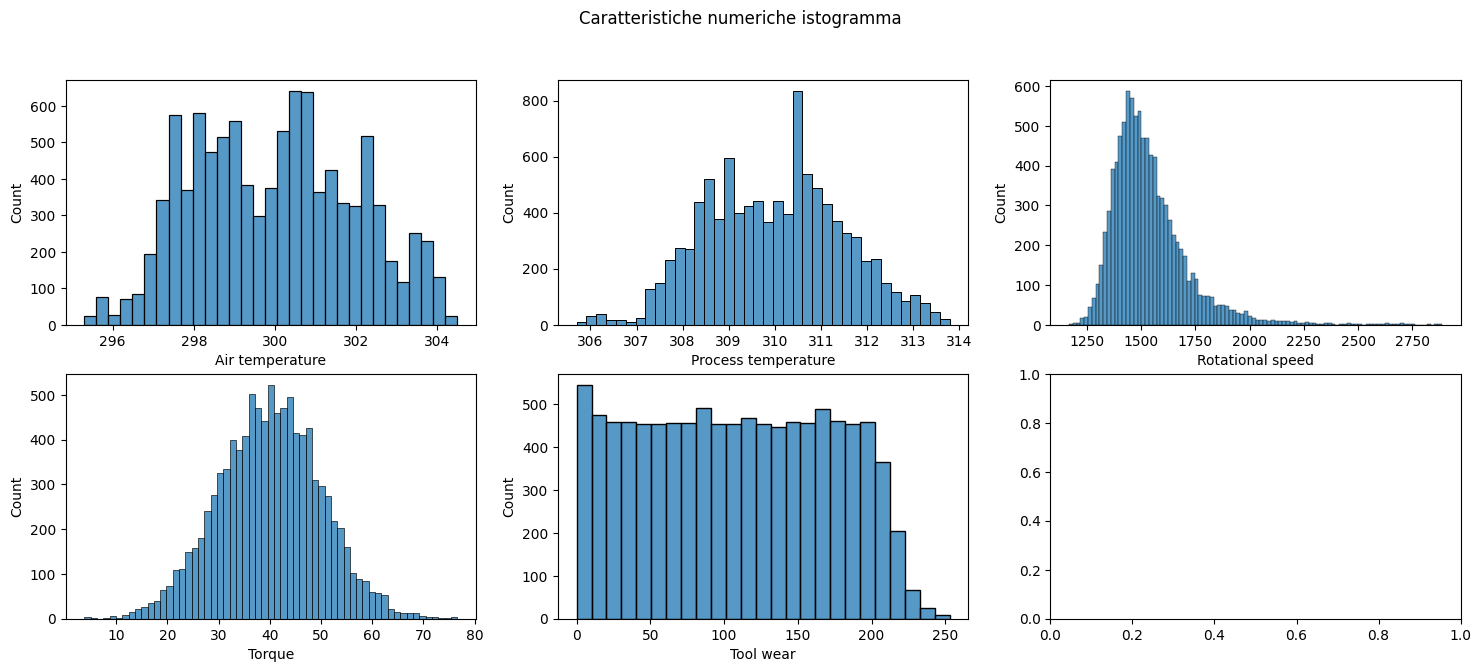

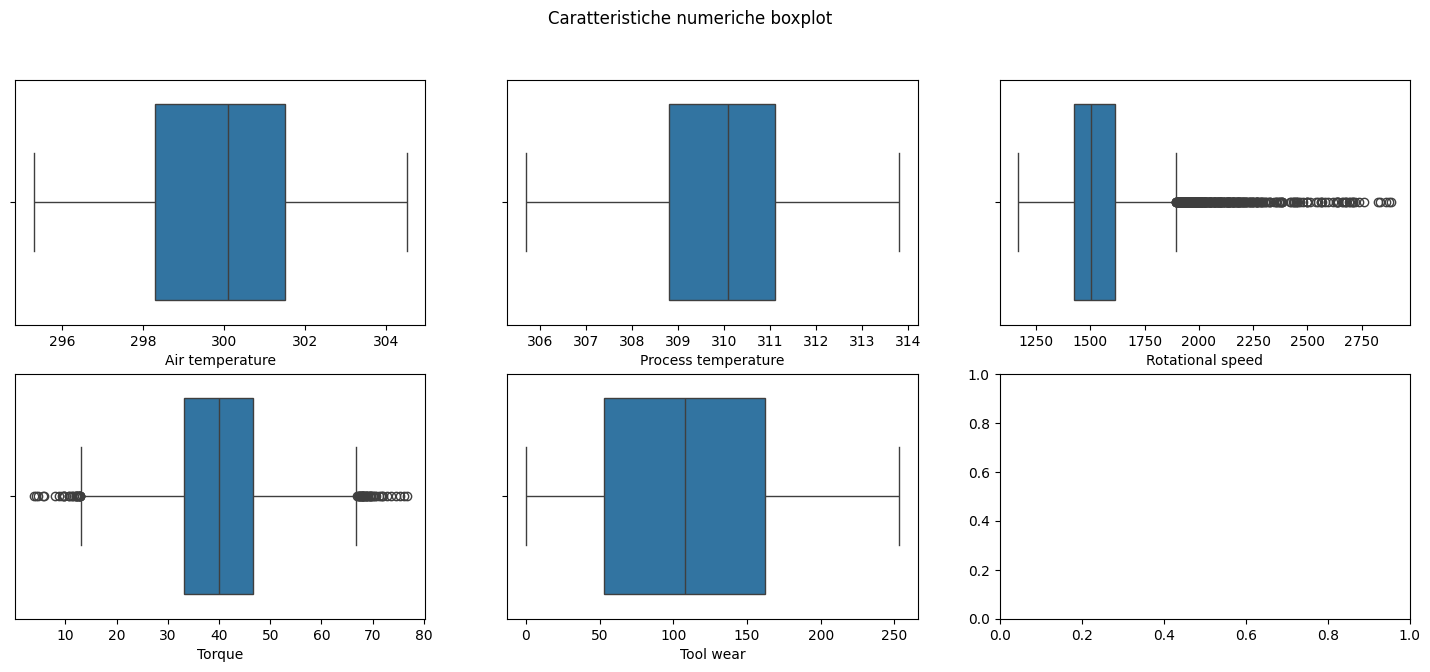

In [11]:

num_features = [feature for feature in features if df[feature].dtype=='float64']
# Histograms of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Caratteristiche numeriche istogramma')
for j, feature in enumerate(num_features):
    sns.histplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

# boxplot of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Caratteristiche numeriche boxplot')
for j, feature in enumerate(num_features):
    sns.boxplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

I boxplot evidenziano possibili valori anomali nelle caratteristiche sopra menzionate, tuttavia nel caso di Torque questi sono probabilmente riconducibili al modo in cui i valori anomali vengono rilevati usando boxplots (poiché la distribuzione è gaussiana sarebbe più appropriato utilizzare la regola 3σ invece dell'IQR); nel caso della velocità di rotazione la distribuzione gaussiana è distorta e non è irrealistico pensare che le poche osservazioni con alta velocità di rotazione stanno per fallire. Per il momento manteniamo i valori anomali e ci riserviamo il diritto di decidere se agire o meno dopo aver considerato altri aspetti.

2.4) Ricampionamento con SMOTE

Un'altra importante considerazione riguarda il bassissimo verificarsi di guasti macchina tra l'intero set di dati, la cui percentuale è pari solo al 3,31%. Inoltre, un grafico a torta che mostra il verificarsi delle cause coinvolte per ogni fallimento rivela un ulteriore grado di squilibrio.

Failures percentage in data: 3.31


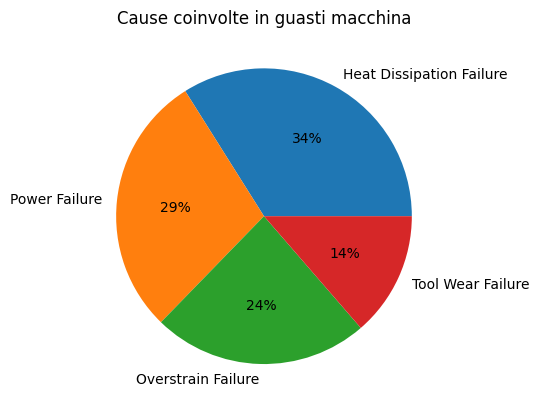

In [12]:
# Porzione di df dove c'è un guasto e causa una percentuale
idx_fail = df.loc[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]
print('Failures percentage in data:',
      round(100*df['Target'].sum()/n,2))
# grafico a torta
plt.title('Cause coinvolte in guasti macchina')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()


Quando si tratta di problemi di apprendimento automatico, lo squilibrio delle classi è una grande preoccupazione, in quanto può fuorviare sia il processo di formazione dei modelli che la nostra capacità di interpretare i loro risultati. Ad esempio, se costruiamo un modello su questo set di dati che prevede che le macchine non falliscano mai, dovrebbe essere accurato al 97%. Per evitare tali effetti e limitare il comportamento preferenziale dei modelli rispetto alle singole classi eseguiamo un aumento dei dati, allo scopo di ottenere un rapporto di 80 a 20 tra osservazioni funzionanti e errate e la stessa percentuale di occorrenza tra le cause coinvolte nei guasti.

Tra le tecniche di aumento dei dati più comuni identifichiamo:

Sotto-campionamento cancellando alcuni punti di dati dalla classe di maggioranza.
Over-Sampling copiando le righe di dati con conseguente classe di minoranza.
Sovracampionamento con SMOTE (Synthetic Minority Oversampling Technique).
Le prime due scelte si traducono tuttavia in approcci estremamente semplicistici; in particolare la prima ha lo svantaggio di diminuire la lunghezza del set di dati in un contesto in cui i dati disponibili sono già limitati. Pertanto usiamo la procedura SMOTE per generare nuovi campioni, che è molto simile a spostare leggermente il punto dati nella direzione dei suoi vicini. In questo modo, il punto di dati sintetici non è una copia esatta di un punto di dati esistente, ma possiamo anche essere sicuri che non è troppo diverso dalle osservazioni note nella classe di minoranza. Per essere più precisi, la procedura SMOTE funziona come segue: disegna un campione casuale dalla classe di minoranza e per le osservazioni in questo campione, identifica i k vicini più vicini. Prenderà quindi uno di questi vicini e identificherà il vettore tra il punto dati corrente e il vicino selezionato. Il vettore viene moltiplicato per un numero casuale compreso tra 0 e 1 e il punto di dati sintetico viene ottenuto aggiungendo questo vettore al punto di dati corrente.

In [13]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
# n_working must represent 80% of the desired length of resampled dataframe
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #samples per class
# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

2.5) Confronto dopo ricampionamento


Percentage increment of observations after oversampling: 20.88
SMOTE Resampled Failures percentage: 20.01


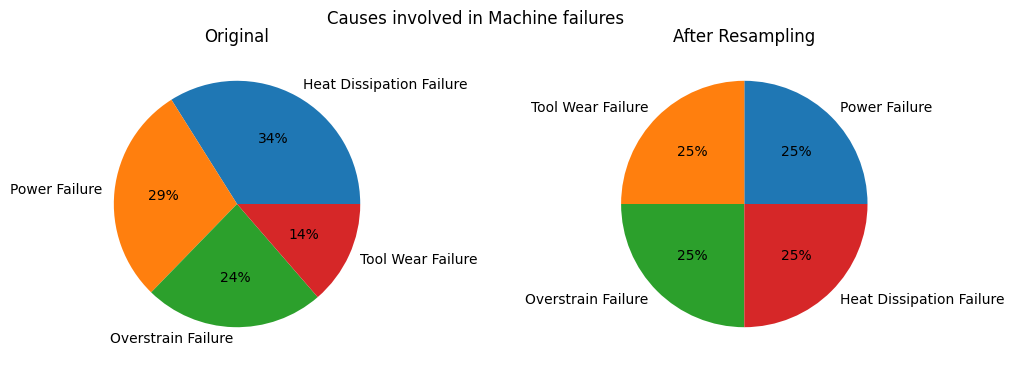

In [14]:
# Portion of df_res where there is a failure and causes percentage
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/df_res_fail.shape[0]

# Percentages
print('Percentage increment of observations after oversampling:',
      round((df_res.shape[0]-df.shape[0])*100/df.shape[0],2))
print('SMOTE Resampled Failures percentage:',
      round(df_res_fail.shape[0]*100/df_res.shape[0],2))

# Pie plot
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
fig.suptitle('Causes involved in Machine failures')
axs[0].pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[1].pie(x=fail_res_percentage.array, labels=fail_res_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[0].title.set_text('Original')
axs[1].title.set_text('After Resampling')
plt.show()

Come ci si può aspettare, i casi di guasto della macchina riguardano principalmente macchine di bassa qualità, quindi quelle di media qualità e solo poche volte quelle di alta qualità. Questa differenza è accentuata quando il numero di osservazioni di macchine non funzionanti è (artificialmente) aumentato. Tuttavia, dal kdeplots sotto si può vedere che questo non è ampiamente correlato con le caratteristiche poiché differenziare in base alla qualità mostra che la distribuzione delle caratteristiche non presenta grandi differenze, tranne che per i due picchi laterali in Tool Wear (che è coerente con la descrizione dei dati). Ciò suggerisce che probabilmente il fatto che la maggior parte dei guasti riguarda macchine di tipo L è dovuto alla maggiore presenza di questo tipo nel set di dati e quindi che la correlazione con il guasto della macchina è dovuta a motivi statistici.

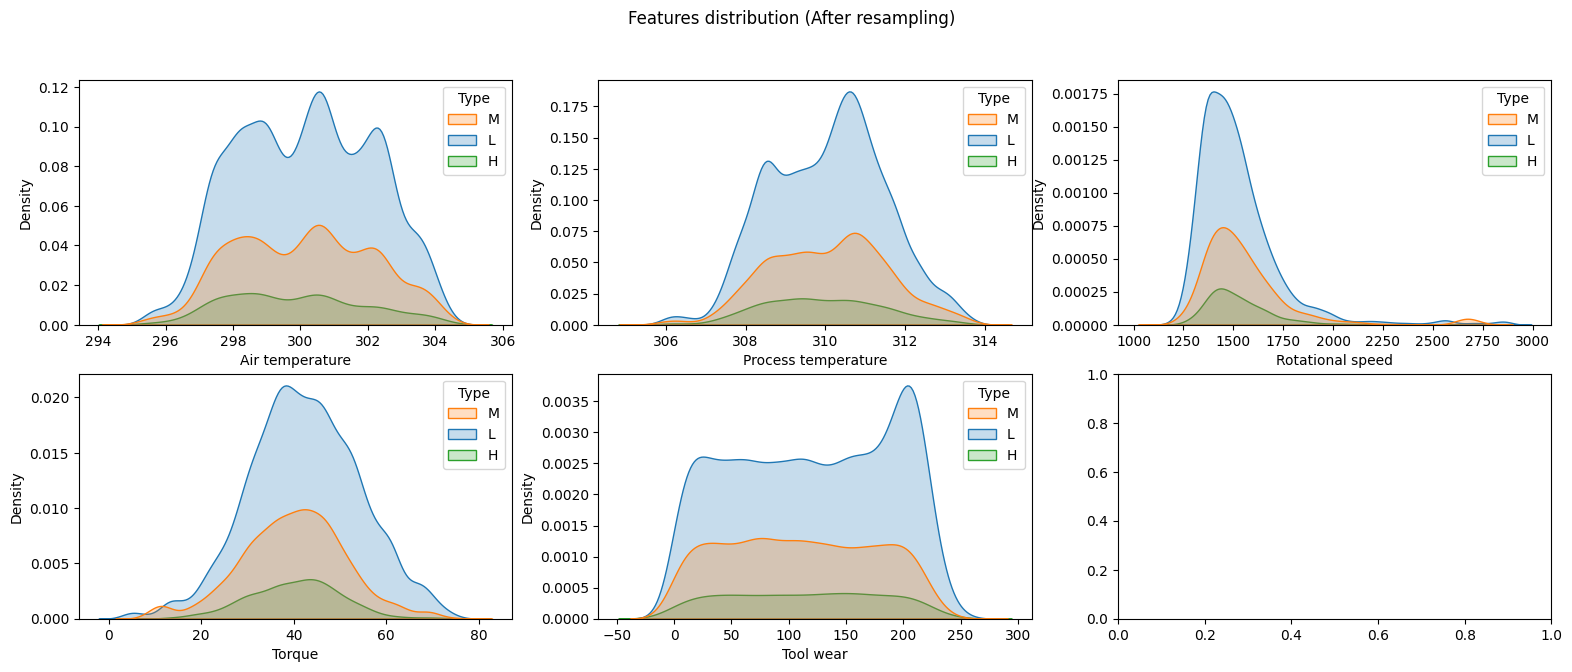

In [15]:
# Kdeplot of numeric features (After resampling) - hue=Type
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(19,7))
fig.suptitle('Features distribution (After resampling)')
custom_palette = {'L':'tab:blue', 'M':'tab:orange', 'H':'tab:green'}
for j, feature in enumerate(num_features):
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
              hue='Type', fill=True, palette=custom_palette)
plt.show()

Infine, diamo un'occhiata a come è cambiata la distribuzione delle funzionalità.

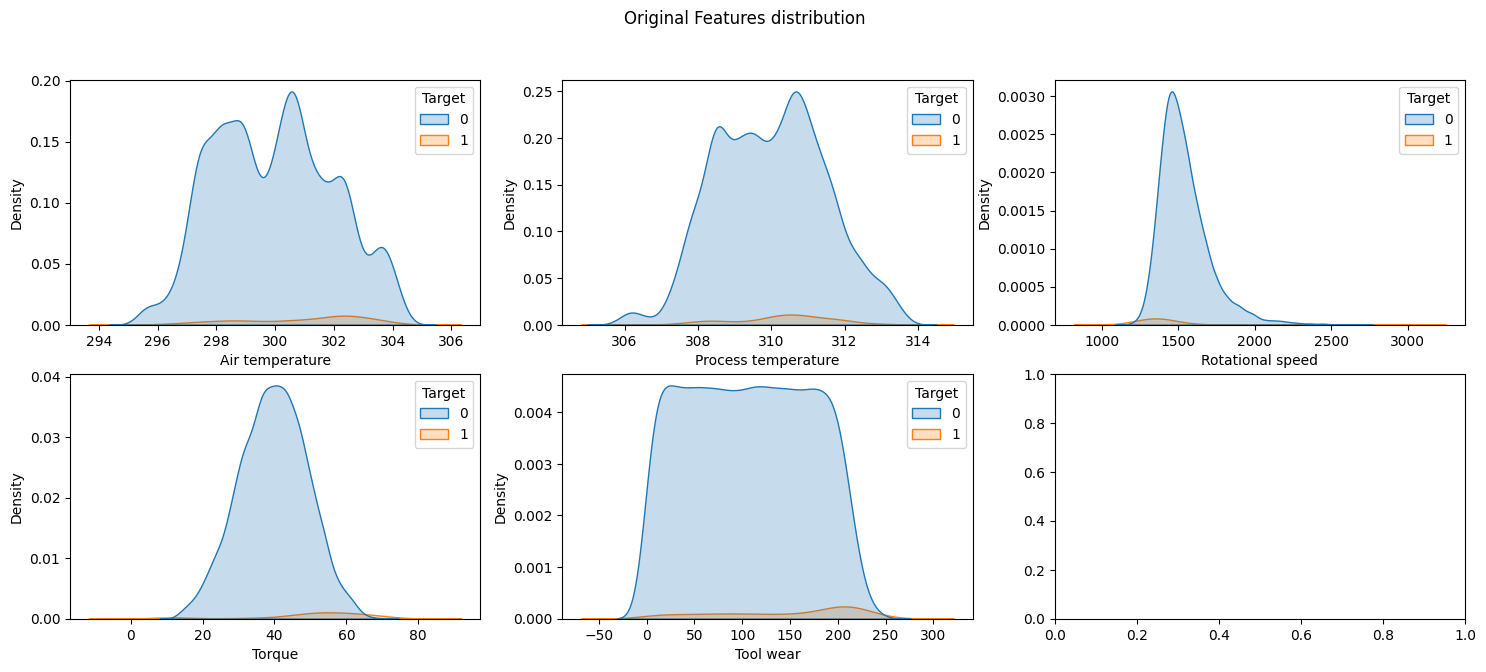

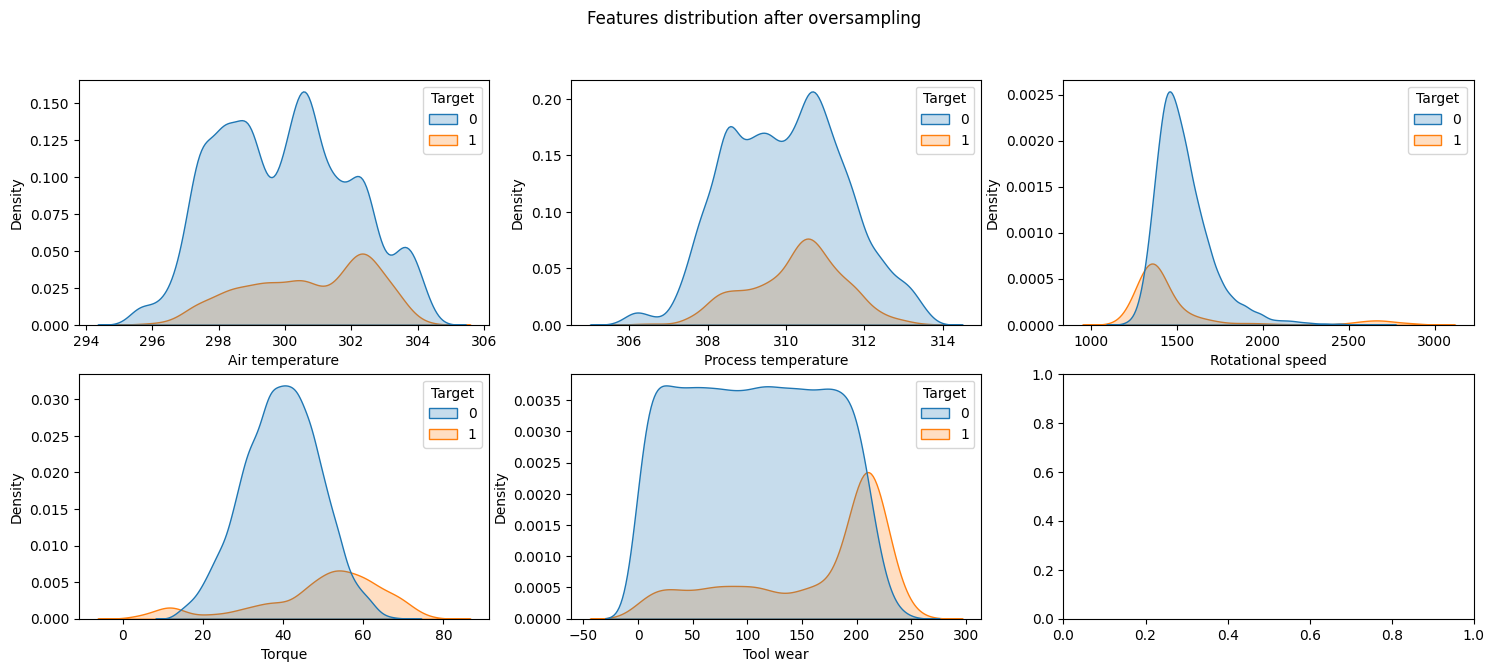

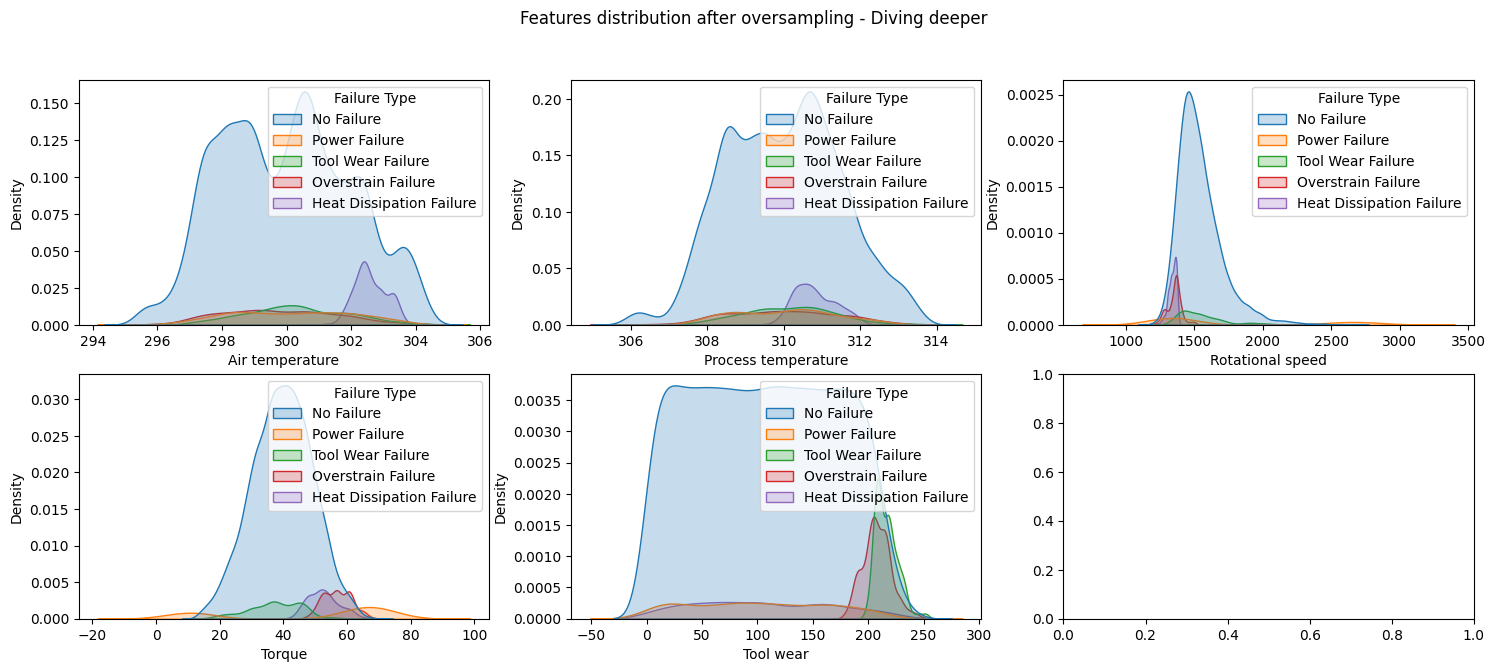

In [16]:
# Kdeplot of numeric features (Original)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Original Features distribution')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature,
                hue='Target', fill=True, palette='tab10')
plt.show()
# Kdeplot of numeric features (After resampling)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Features distribution after oversampling')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
                hue=df_res['Target'], fill=True, palette='tab10')
plt.show()
# Kdeplot of numeric features (After resampling) - Diving deeper
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Features distribution after oversampling - Diving deeper')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
                hue=df_res['Failure Type'], fill=True, palette='tab10')
plt.show()

La prima cosa che possiamo osservare è che l'aumento dei dati è stato eseguito con successo, poiché la distribuzione delle funzionalità per le istantanee difettose non è stata significativamente distorta. Si noti inoltre che in Velocità di rotazione, Coppia e Usura utensile le osservazioni relative ai guasti hanno un picco di densità nelle zone estreme della distribuzione. Ciò implica che i valori anomali che abbiamo discusso nella Sezione 2.3 non devono essere imputati a errori nella costruzione del set di dati, ma piuttosto alla naturale varianza dello stesso. Questo diventa ancora più chiaro osservando le distribuzioni relative alle singole cause di guasto: in particolare, un comportamento quasi simmetrico è riconosciuto in Velocità di rotazione e Coppia mentre in Usura utensile si osserva una netta separazione tra guasti PWF e HDF su valori più bassi e picchi che si trovano a valori più elevati rispetto a TWF e OSF. Ciò è perfettamente coerente con la descrizione degli obiettivi riportata nella sezione "Descrizione di task e set di dati".

2.6) Funzioni di ridimensionamento e codifica

Per rendere i dati sfruttabili per gli algoritmi che eseguiremo, applichiamo due trasformazioni:

Innanzitutto, applichiamo una codifica di etichetta alle colonne categoriche, poiché Tipo è una funzione ordinale e Causa deve essere rappresentato in una colonna. La mappatura segue questo schema: Tipo: {L=0, M=1, H=2} Causa: {Working=0, PWF=1, OSF=2, HDF=3, TWF=4}
In secondo luogo eseguiamo il ridimensionamento delle colonne con StandardScaler. Ciò è particolarmente utile per il buon funzionamento di metodi che si basano sullo spazio metrico, come PCA e KNN. È stato anche verificato che l'utilizzo di StandardScaler porta a prestazioni leggermente migliori rispetto all'utilizzo di MinMaxScaler.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4}
df_pre = df_res.copy()
# Encoding
df_pre['Type'].replace(to_replace=type_dict, inplace=True)
df_pre['Failure Type'].replace(to_replace=cause_dict, inplace=True)
# Scaling
df_pre[num_features] = sc.fit_transform(df_pre[num_features])

2.7) PCA e mappa di correlazione

Eseguiamo PCA per avere un ulteriore modo di visualizzare i dati invece di fare la selezione delle caratteristiche.

In [18]:
pca = PCA(n_components=len(num_features))
X_pca = pd.DataFrame(data=pca.fit_transform(df_pre[num_features]), columns=['PC'+str(i+1) for i in range(len(num_features))])
var_exp = pd.Series(data=100*pca.explained_variance_ratio_, index=['PC'+str(i+1) for i in range(len(num_features))])
print('Explained variance ratio per component:', round(var_exp,2), sep='\n')
print('Explained variance ratio with 3 components: '+str(round(var_exp.values[:3].sum(),2)))

Explained variance ratio per component:
PC1    37.69
PC2    36.81
PC3    19.84
PC4     3.08
PC5     2.58
dtype: float64
Explained variance ratio with 3 components: 94.34


Dal momento che i primi tre componenti sono sufficienti a rappresentare quasi completamente la varianza dei dati li proietteremo in uno spazio tridimensionale.

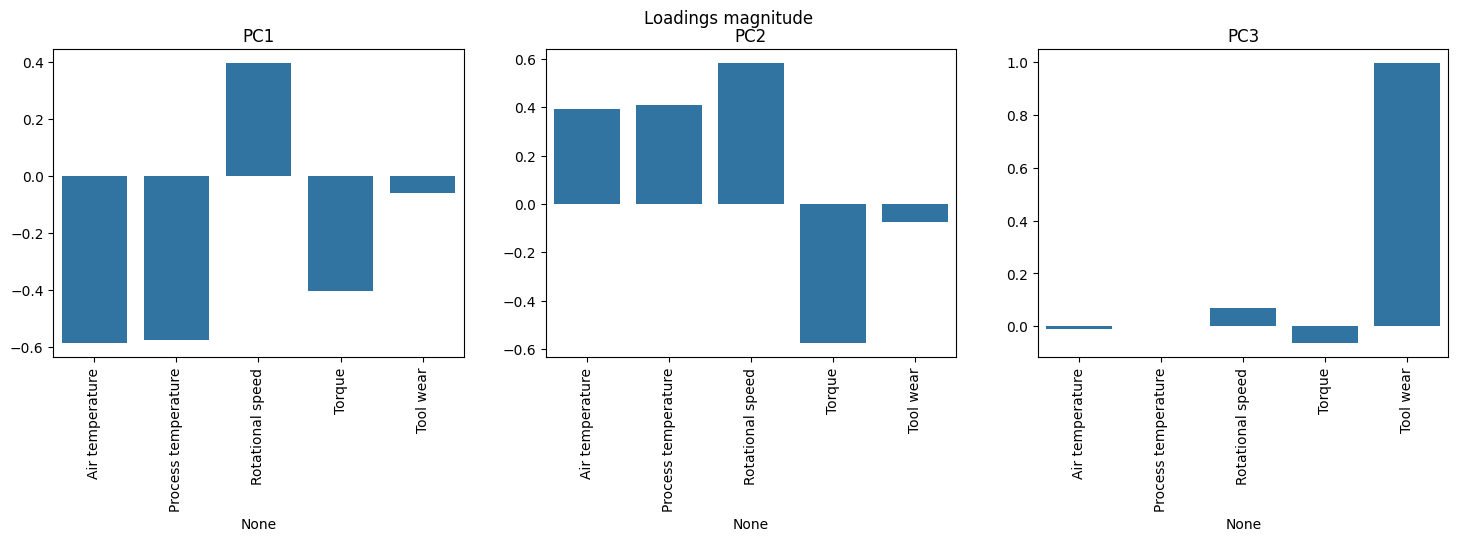

In [19]:

# PCA for Data visualization
pca3 = PCA(n_components=3)
X_pca3 = pd.DataFrame(data=pca3.fit_transform(df_pre[num_features]), columns=['PC1','PC2','PC3'])

# Loadings Analysis
fig, axs = plt.subplots(ncols=3, figsize=(18,4))
fig.suptitle('Loadings magnitude')
pca_loadings = pd.DataFrame(data=pca3.components_, columns=num_features)
for j in range(3):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()

Il grafico a barre dei pesi dei componenti principali rende facile capire cosa rappresentano:

PC1 è strettamente correlato ai due dati di temperatura;
PC2 può essere identificato con la potenza della macchina, che è il prodotto di velocità di rotazione e coppia;
PC3 è identificabile con Tool Wear.

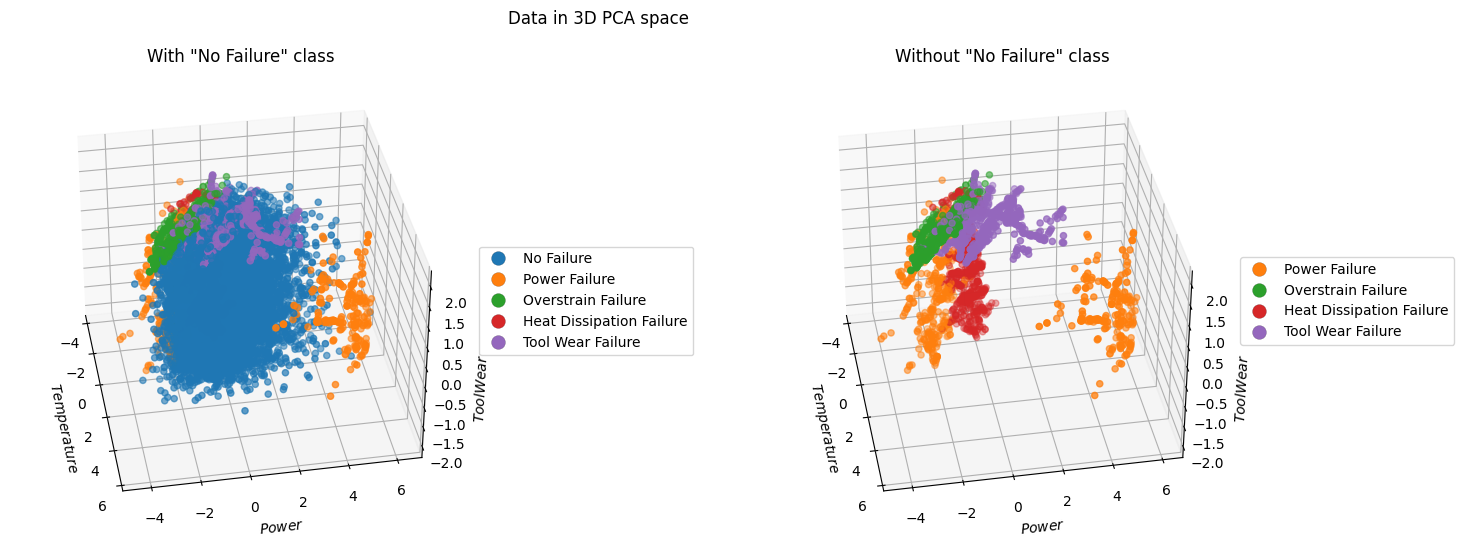

In [20]:
X_pca3.rename(mapper={'PC1':'Temperature',
                      'PC2':'Power',
                      'PC3':'Tool Wear'}, axis=1, inplace=True)

# PCA plot
color = []
col = df_pre['Failure Type'].map({0:'tab:blue',1:'tab:orange',2:'tab:green',3:'tab:red',4:'tab:purple'})
color.append(col)
idx_w = col[col == 'tab:blue'].index
color.append(col.drop(idx_w))
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
labelTups = [('No Failure','tab:blue'),
             ('Power Failure', 'tab:orange'),
             ('Overstrain Failure','tab:green'),
             ('Heat Dissipation Failure', 'tab:red'),
             ('Tool Wear Failure','tab:purple')]

fig = plt.figure(figsize=(18,6))
fig.suptitle('Data in 3D PCA space')
full_idx = X_pca3.index

for j, idx in enumerate([full_idx,idx_fail_res]):
    ax = fig.add_subplot(1, 2, j+1, projection='3d')

    lg = ax.scatter(X_pca3.loc[idx,'Temperature'],
                    X_pca3.loc[idx,'Power'],
                    X_pca3.loc[idx,'Tool Wear'],
                    c=color[j])
    ax.set_xlabel('$Temperature$')
    ax.set_ylabel('$Power$')
    ax.set_zlabel('$Tool Wear$')
    ax.title.set_text('With'+str(j*'out')+' "No Failure" class')
    ax.view_init(35, -10)
    custom_lines = [plt.Line2D([],[], ls="", marker='.',
                               mec='k', mfc=c, mew=.1, ms=20) for c in colors[j:]]
    ax.legend(custom_lines, [lt[0] for lt in labelTups[j:]],
              loc='center left', bbox_to_anchor=(1.0, .5))

plt.show()

La proiezione nello spazio generata da questi tre assi evidenzia che: che il primo è caratterizzato da un'elevata usura degli utensili e bassa potenza mentre il secondo è

TWF è la classe di guasti meglio separata da tutte le altre e sembra dipendere quasi interamente da PC3 (Tool Wear);
PWF occupa due bande estreme lungo il PC2 (Power), è indipendente dagli altri due componenti; 18
Le classi OSF e HDF sono meno separate delle altre anche se si può osservare
caratterizzato da una temperatura elevata e una bassa potenza.

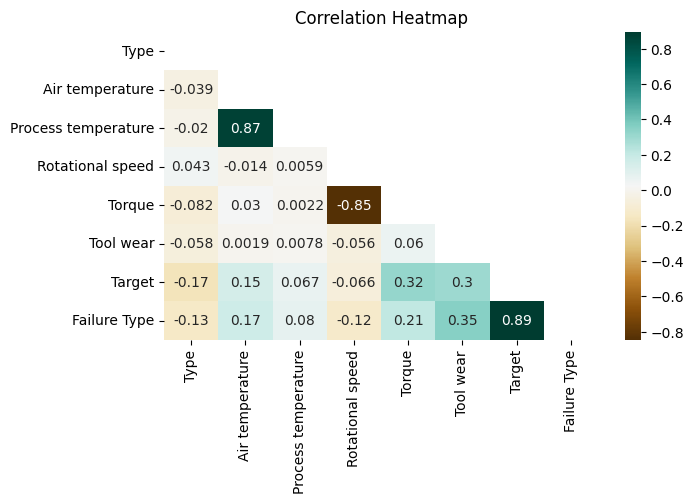

In [21]:
# Correlation Heatmap
plt.figure(figsize=(7,4))
sns.heatmap(data=df_pre.corr(), mask=np.triu(df_pre.corr()), annot=True, cmap='BrBG')
plt.title('Correlation Heatmap')
plt.show()

Non sorprende che le caratteristiche legate alla temperatura, così come quelle legate alla potenza, siano ampiamente correlate. Inoltre, Tool Wear si correla bene con entrambi i nostri obiettivi, confermando ciò che abbiamo osservato studiando PCA. Infine, si osserva anche una correlazione meno forte tra la torsione e i due bersagli.

2.8) Metrics

L'obiettivo di questa sezione è quello di trovare il miglior modello per la classificazione binaria del set di dati per prevedere se ci sarà o meno guasto macchina. Gli algoritmi di classificazione fanno parte del data mining e utilizzano metodi di apprendimento automatico supervisionati per fare previsioni sui dati. In particolare, un insieme di dati già divisi ("etichettati") in due o più classi di appartenenza viene fornito come input grazie al quale viene creato un modello di classificazione, che verrà utilizzato su nuovi dati ("non etichettati") per assegnarli alla classe appropriata. Il set di dati di partenza è di solito diviso in tre gruppi: il set di dati di formazione, i.e. il campione di dati utilizzati per adattarsi al modello, il set di dati di convalida, i.e. il campione di dati utilizzato per fornire una valutazione di un adattamento del modello sul set di dati di allenamento mentre si sintonizza il modello iperparametri e il set di dati di prova, che ha lo scopo di testare il modello. All'inizio di un progetto uno scienziato di dati deve fare questa divisione ed i rapporti comuni usati sono:

70% treno, 15% val, 15% test.
80% treno, 10% val, 10% test.
60% treno, 20% val, 20% test.
In questo progetto usiamo il rapporto (80/10/10) per la divisione perché testiamo il modello per tutte queste strategie e scopriamo che è il migliore. Le tecniche di classificazione che scegliamo di implementare sono le seguenti: prevedere mentre le variabili indipendenti o le variabili esplicative sono i fattori che

Regressione logistica: stima la probabilità di una variabile dipendente in funzione di variabili indipendenti. La variabile dipendente è l'output che stiamo cercando di
tatto potrebbe influenzare la produzione. Per la sua semplicità e interpretabilità, decidiamo di utilizzare la Regressione Logistica come modello di Benchmark, un modello di base che rappresenta il punto di partenza per confrontare i risultati ottenuti da altri modelli.
K-nearest neighbors (K-NN): algoritmo basato sul calcolo della distanza tra gli elementi del set di dati. I dati sono assegnati a una certa classe se abbastanza vicini agli altri dati della stessa classe. Il parametro K rappresenta il numero di dati vicini presi in considerazione quando si assegnano le classi.
Macchina vettoriale di supporto: il suo scopo è quello di trovare un iperpiano in uno spazio N-dimensionale (N-il numero di caratteristiche) che classifica distintamente i punti di dati, massimizzando la distanza di margine, i.e. la distanza tra i punti di dati di entrambe le classi.
Foresta casuale: utilizza l'apprendimento ensemble, che è una tecnica che combina molti classificatori per fornire soluzioni a problemi complessi. Random Forest usa la tecnica del bagging: costruisce una moltitudine di alberi decisionali in parallelo, tutti con la stessa importanza, e l'output è la classe selezionata dalla maggior parte degli alberi.
XGBoost: è un albero di decisione potenziato dal gradiente (GBDT). A Gradient Boosting Decision Tree (GBDT) è un algoritmo di apprendimento dell'albero decisionale simile a Random Forest, da cui differisce perché utilizza una tecnica di potenziamento: allena iterativamente un insieme di alberi decisionali poco profondi, con ogni iterazione utilizzando i residui di errore del modello precedente per adattarsi al modello successivo. La previsione finale è una somma ponderata di tutte le previsioni degli alberi.

In [22]:
#importazione bibliotecche machine learning e divisione dei nostri data
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import time

# train-validation-test split
X, y = df_pre[features], df_pre[['Target','Failure Type']]
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=df_pre['Failure Type'], random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11, stratify=y_trainval['Failure Type'], random_state=0)

Definiamo alcune funzioni per facilitare la lettura delle seguenti sottosezioni.

In [23]:
"""User-defined function: Evaluate cm, accurcay, AUC, F1 for a given classifier
- model, fitted estimator.
- X, data used to estimate class probabilities (paired with y_true)
- y_true, ground truth with two columns
- y_pred, predictions
- task = 'binary','multi_class'
"""
def eval_preds(model,X,y_true,y_pred,task):
    if task == 'binary':
        # Extract task target
        y_true = y_true['Target']
        cm = confusion_matrix(y_true, y_pred)
        # Probability of the minority class
        proba = model.predict_proba(X)[:,1]
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        f2 = fbeta_score(y_true, y_pred, pos_label=1, beta=2)
    elif task == 'multi_class':
        y_true = y_true['Failure Type']
        cm = confusion_matrix(y_true, y_pred)
        proba = model.predict_proba(X)
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    metrics = pd.Series(data={'ACC':acc, 'AUC':auc, 'F1':f1, 'F2':f2})
    metrics = round(metrics,3)
    return cm, metrics
"""User-defined function: Fits one estimator using GridSearch to search for the best parameters
- clf, estimator
- X, y = X_train, y_train
- params, parameters grid for GridSearch
- task = 'binary','multi_class'
"""
def tune_and_fit(clf,X,y,params,task):
    if task=='binary':
        f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                                cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Target'])
    elif task=='multi_class':
        f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                              cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Failure Type'])

    print('Best params:', grid_model.best_params_)
    # Print training times
    train_time = time.time()-start_time
    mins = int(train_time//60)
    print('Training time: '+str(mins)+'m '+str(round(train_time-mins*60))+'s')
    return grid_model



"""User-defined function: Makes predictions using the tuned classifiers.
Then uses eval_preds to compute the relative metrics. Returns:
- y_pred, DataFrame containing the predictions of each model
- cm_list, confusion matrix list
- metrics, DataFrame containing the metrics
Input:- fitted_models, fitted estimators
- X, data used to make predictions
- y_true, true values for target
- clf_str, list containing estimators names
- task = 'binary','multi_class'
"""
def predict_and_evaluate(fitted_models,X,y_true,clf_str,task):
    cm_dict = {key: np.nan for key in clf_str}
    metrics = pd.DataFrame(columns=clf_str)
    y_pred = pd.DataFrame(columns=clf_str)
    for fit_model, model_name in zip(fitted_models,clf_str):
        # Update predictions
        y_pred[model_name] = fit_model.predict(X)
        # Metrics
        if task == 'binary':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)
        elif task == 'multi_class':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)
        # Update Confusion matrix and metrics
        cm_dict[model_name] = cm
        metrics[model_name] = scores
    return y_pred, cm_dict, metrics



"""User-defined function: Fit the estimators on multiple classifiers
- clf, estimators
- clf_str, list containing estimators names
- X_train,y_train, data used to fit models
- X_val,y_val, data used to validate models
"""

def fit_models(clf,clf_str,X_train,X_val,y_train,y_val):
    metrics = pd.DataFrame(columns=clf_str)
    for model, model_name in zip(clf, clf_str):
        model.fit(X_train,y_train['Target'])
        y_val_pred = model.predict(X_val)
        metrics[model_name] = eval_preds(model,X_val,y_val,y_val_pred,'binary')[1]
    return metrics

3.2) Tentativi di selezione delle funzionalità

Prima di entrare nell'allenamento dei modelli appena citati cerchiamo di effettuare la selezione delle caratteristiche, sfruttando le considerazioni che abbiamo fatto sulla mappa di correlazione e l'analisi dei dati esplorativa: solo per ricordare, abbiamo notato che le caratteristiche "Temperatura di processo" e La "temperatura dell'aria" è correlata positivamente e "Coppia" e "Velocità di rotazione" sono correlate negativamente. Dalla descrizione del dateset vediamo che il guasto PWF si verifica se il prodotto tra "Coppia" e "Velocità di rotazione" è in un certo intervallo di valori e, analogamente, il guasto HDF si verifica quando la differenza tra "Temperatura dell'aria" e "Temperatura di processo" supera un determinato valore. Per questi motivi, cancellare completamente queste colonne sembra essere una cattiva scelta perché le informazioni importanti possono essere perse ma allo stesso tempo è ragionevole vedere cosa succede se le combiniamo, prese da coppie, per creare nuove caratteristiche che conservano ancora un significato fisico. Si procede quindi a confrontare i risultati ottenuti inserendo i modelli di classificazione senza sintonizzare alcun parametro sui seguenti set di dati:

quella originale;
quella ottenuta rimuovendo le colonne "Temperatura di processo" e "Temperatura aria", sostituendole con una colonna del loro prodotto;
quella ottenuta rimuovendo "Coppia" e "Velocità di rotazione", sostituendoli con una colonna del loro prodotto;
a combinare le operazioni precedenti.

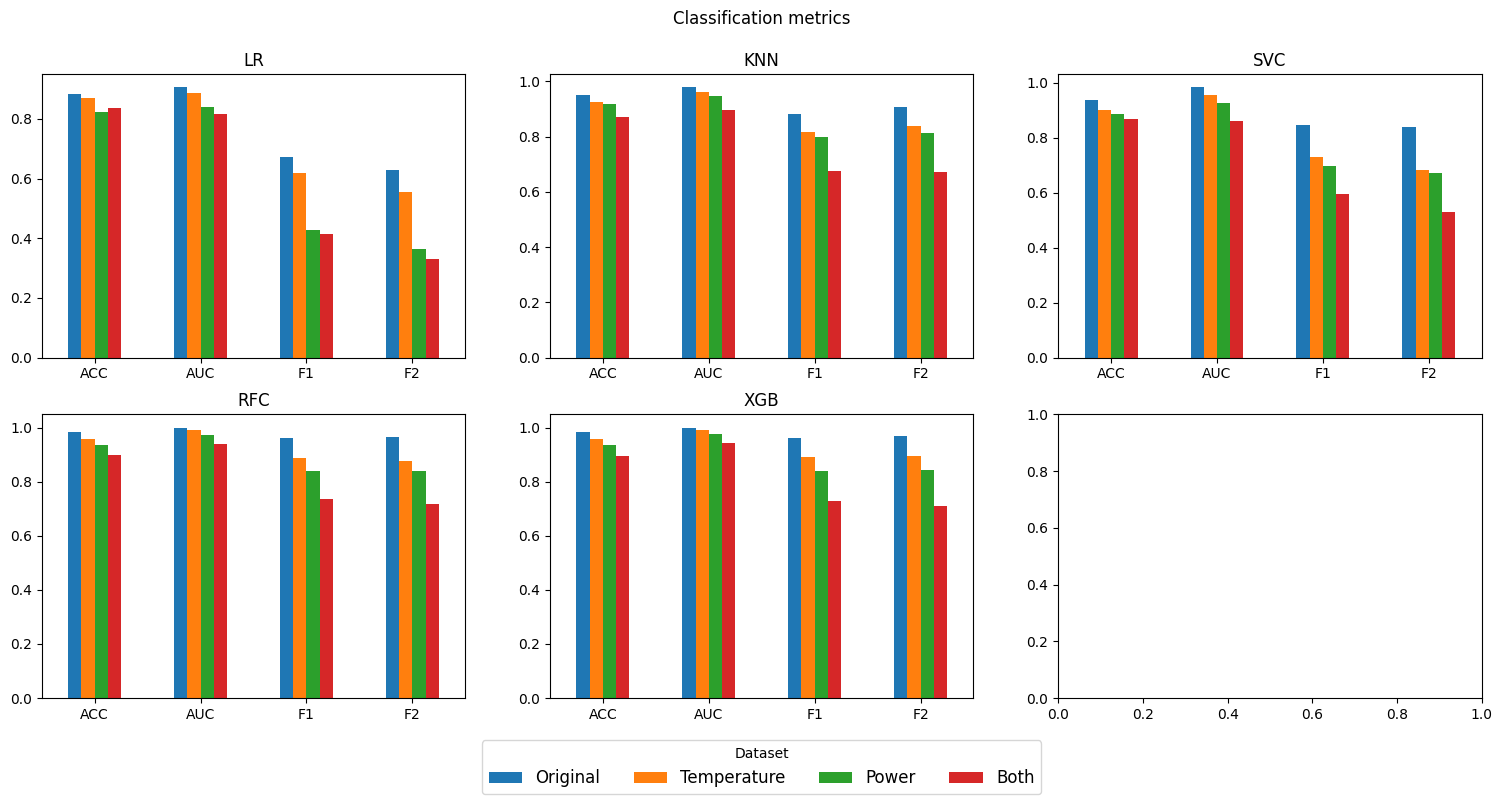

In [24]:
# Models
lr = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC(probability=True)
rfc = RandomForestClassifier()
xgb = XGBClassifier()

clf = [lr,knn,svc,rfc,xgb]
clf_str = ['LR','KNN','SVC','RFC','XGB']

# Fit on raw train
metrics_0 = fit_models(clf,clf_str,X_train,X_val,y_train,y_val)

# Fit on temperature product train
XX_train = X_train.drop(columns=['Process temperature','Air temperature'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature'] = X_val['Process temperature']*X_val['Air temperature']
metrics_1 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# Fit on power product train
XX_train = X_train.drop(columns=['Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Rotational speed','Torque'])
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']
metrics_2 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# Fit on both products train
XX_train = X_train.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature']= X_val['Process temperature']*X_val['Air temperature']
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']
metrics_3 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# classification metrics barplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,8))
fig.suptitle('Classification metrics')
for j, model in enumerate(clf_str):
    ax = axs[j//3,j-3*(j//3)]
    model_metrics = pd.DataFrame(data=[metrics_0[model],metrics_1[model],metrics_2[model],metrics_3[model]])
    model_metrics.index = ['Original','Temperature','Power','Both']
    model_metrics.transpose().plot(ax=ax, kind='bar', rot=0, )
    ax.title.set_text(model)
    ax.get_legend().remove()
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)
axs.flatten()[-2].legend(title='Dataset', loc='upper center',
                         bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=12)
plt.show()

From the results obtained, we observe that all the models applied to the entire dataset perform better than when they are applied to the ones created by reducing the number of features. The best performances and the modest number of features from which our dataset is composed encourage us to opt to avoid the feature selection step.

3.3) Logistic Regression Benchmark

We decide to use Logistic Regression as a Benchmark for our task. It represents an intermediate step between the basic model referred to in Section 2.4 and the more complex models that we have described and we will explore in depth in the following sections. Now we look at the results obtained and at the interpretability of the model.

3.3) Benchmark di regressione logistica


Decidiamo di usare la regressione logistica come punto di riferimento per il nostro compito. Rappresenta un passo intermedio tra il modello di base di cui alla sezione 2.4 e i modelli più complessi che abbiamo descritto e che esploreremo in profondità nelle sezioni seguenti. Ora guardiamo i risultati ottenuti e l'interpretabilità del modello.

Validation set metrics:
ACC    0.883
AUC    0.905
F1     0.673
F2     0.629
dtype: float64
Test set metrics:
ACC    0.881
AUC    0.917
F1     0.655
F2     0.598
dtype: float64


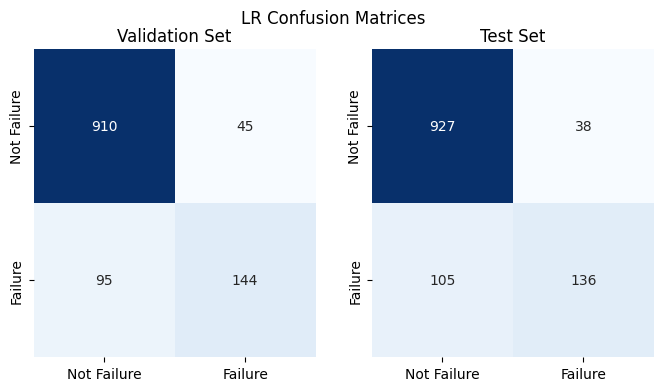

,feature,odds
4,Torque,16.696209
3,Rotational speed,9.394822
1,Air temperature,4.462500
5,Tool wear,3.483306
0,Type,0.520599
2,Process temperature,0.348815


In [25]:
# Make predictions
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train['Target'])
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# Metrics
cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'binary')
cm_test_lr, metrics_test_lr = eval_preds(lr,X_test,y_test,y_test_lr,'binary')
print('Validation set metrics:',metrics_val_lr, sep='\n')
print('Test set metrics:',metrics_test_lr, sep='\n')

cm_labels = ['Not Failure', 'Failure']
cm_lr = [cm_val_lr, cm_test_lr]
# Show Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
fig.suptitle('LR Confusion Matrices')
for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True,
              fmt='d', cmap='Blues', cbar=False)
    axs[j].title.set_text(title)
    axs[j].set_xticklabels(cm_labels)
    axs[j].set_yticklabels(cm_labels)
plt.show()

# Odds for interpretation
d = {'feature': X_train.columns, 'odds': np.exp(lr.coef_[0])}
odds_df = pd.DataFrame(data=d).sort_values(by='odds', ascending=False)
odds_df

Le probabilità di regressione logistica ci permettono di capire come funziona il modello. In particolare, viene data un'importanza irrealisticamente elevata alla coppia e alla velocità di rotazione. Ciò è dovuto principalmente alla variazione naturale in queste caratteristiche, che è particolarmente elevata quando si guardano solo i casi di fallimento e tende a "deviare" il modello. Tuttavia è ragionevole ritenere, sulla base di un'analisi esplorativa, che i primi quattro aspetti abbiano una rilevanza significativamente maggiore rispetto agli ultimi due. Ci aspettiamo anche una maggiore affidabilità dei valori delle quote quando applichiamo la regressione logistica al compito multiclasse, poiché gli effetti che si diffondono qui sembrano essere localizzati intorno a certi tipi di guasti.

3.4-model

In [34]:
# Models
knn = KNeighborsClassifier()
svc = SVC()
rfc = RandomForestClassifier()
xgb = XGBClassifier()
clf = [knn, svc, rfc, xgb]
clf_str = ['KNN', 'SVC', 'RFC', 'XGB']

# Parameter grids for GridSearch
knn_params = {'n_neighbors': [1, 3, 5, 8, 10]}
svc_params = {'C': [1, 10, 100],
              'gamma': [0.1, 1],
              'kernel': ['rbf'],
              'probability': [True],
              'random_state': [0]}
rfc_params = {'n_estimators': [100, 300, 500, 700],
              'max_depth': [5, 7, 10],
              'random_state': [0]}
xgb_params = {'n_estimators': [300, 500, 700],
              'max_depth': [5, 7],
              'learning_rate': [0.01, 0.1],
              'objective': ['binary:logistic']}
params = pd.Series(data=[knn_params, svc_params, rfc_params, xgb_params], index=clf)

# Tune hyperparameters with GridSearch (estimated time 8m)
print('GridSearch start')
fitted_models_binary = []
for model, model_name in zip(clf, clf_str):
    print('Training ' + str(model_name))
    fit_model = tune_and_fit(model, X_train, y_train, params[model], 'binary')
    fitted_models_binary.append(fit_model)

GridSearch start
Training KNN
Best params: {'n_neighbors': 1}
Training time: 0m 4s
Training SVC
Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 1m 49s
Training RFC
Best params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 0}
Training time: 3m 12s
Training XGB
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700, 'objective': 'binary:logistic'}
Training time: 0m 49s


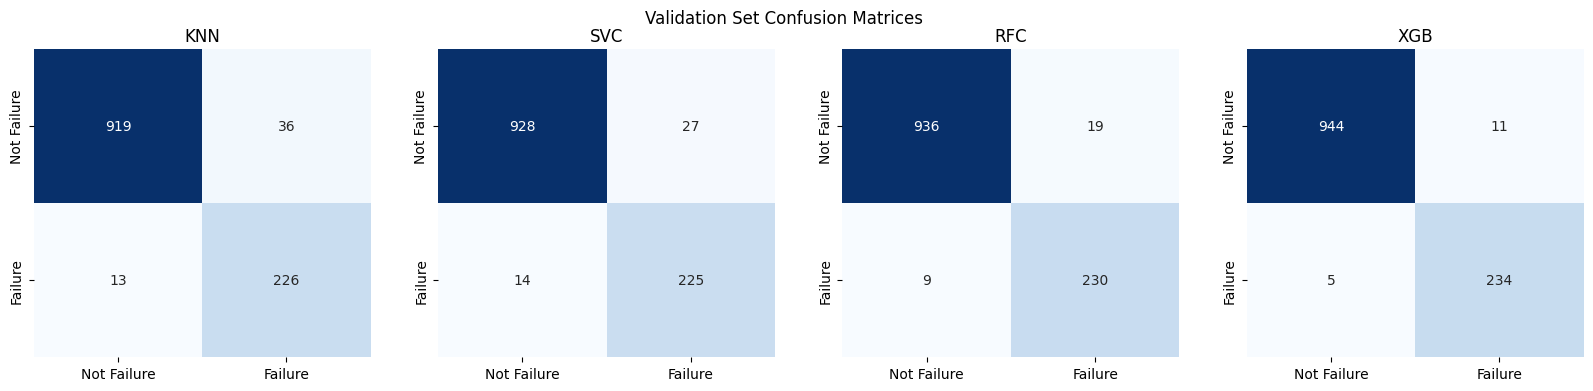

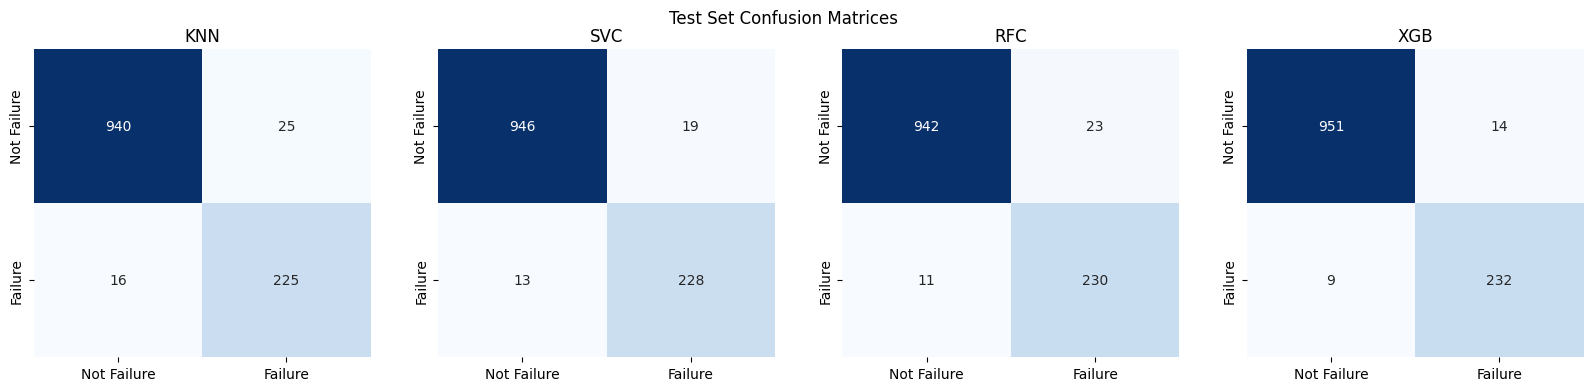


Validation scores:
       KNN    SVC    RFC    XGB
ACC  0.959  0.966  0.977  0.987
AUC  0.954  0.987  0.997  0.999
F1   0.902  0.916  0.943  0.967
F2   0.928  0.931  0.954  0.974
Test scores:
       KNN    SVC    RFC    XGB
ACC  0.966  0.973  0.972  0.981
AUC  0.954  0.992  0.997  0.998
F1   0.916  0.934  0.931  0.953
F2   0.927  0.941  0.945  0.959


In [27]:

# Create evaluation metrics
task = 'binary'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_binary,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_binary,X_test,y_test,clf_str,task)

# Show Validation Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Validation Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Show Test Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Print scores
print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

Tutti i modelli selezionati ottengono risultati simili sul set di validazione (tranne KNN che è un po' peggio) ed è diffj7icult per determinare se uno funziona meglio di un altro guardando solo a questi valori. Le prestazioni non sono diminuite in modo significativo quando si è superato il set di prova, dimostrando che è stato evitato il overfitting. Commentiamo i risultati dei modelli osservando le matrici di confusione e le metriche ottenute sul set di test: in questo modo la formazione di una gerarchia tra i modelli utilizzati è leggermente più chiara, poiché tutte le metriche relative a un singolo modello sono più piccole o più grandi rispetto alle altre e il tempo necessario per la ricerca dei parametri è paragonabile, con l'unica eccezione di KNN. In particolare KNN ottiene le prestazioni peggiori e XGB le migliori; al centro troviamo SVC e RFC che raggiungono risultati estremamente simili.

Informazioni sui parametri:

È stata avviata una Gridsearch sui parametri che, guardando in letteratura, appaiono preponderanti per ogni specifico modello;
I valori della griglia da cercare sono stati definiti sulla base della letteratura e di vari test, cercando di mantenere il costo computazionale di trovare i migliori valori moderati.
È interessante osservare che i parametri ottimali per RFC e XGB sono il polo opposto: il primo preferisce utilizzare pochi stimatori e andare in profondità mentre il secondo utilizza più stimatori con meno spaccature. Inoltre, si deve tener conto del fatto che, sebbene XGB sia il miglior classificatore dal punto di vista quantitativo, ciò non è vero per quanto riguarda il lato qualitativo. Sia SVC che XGB infatti mancano di modi chiari per interpretare i risultati, mentre al contrario RFC permette di avere una comprensione completa di come l'algoritmo ha funzionato. In ogni caso, per avere un'idea di quali caratteristiche hanno avuto maggiore importanza nel fare le previsioni, riportiamo le importanze della funzione di permutazione in un grafico a barre.

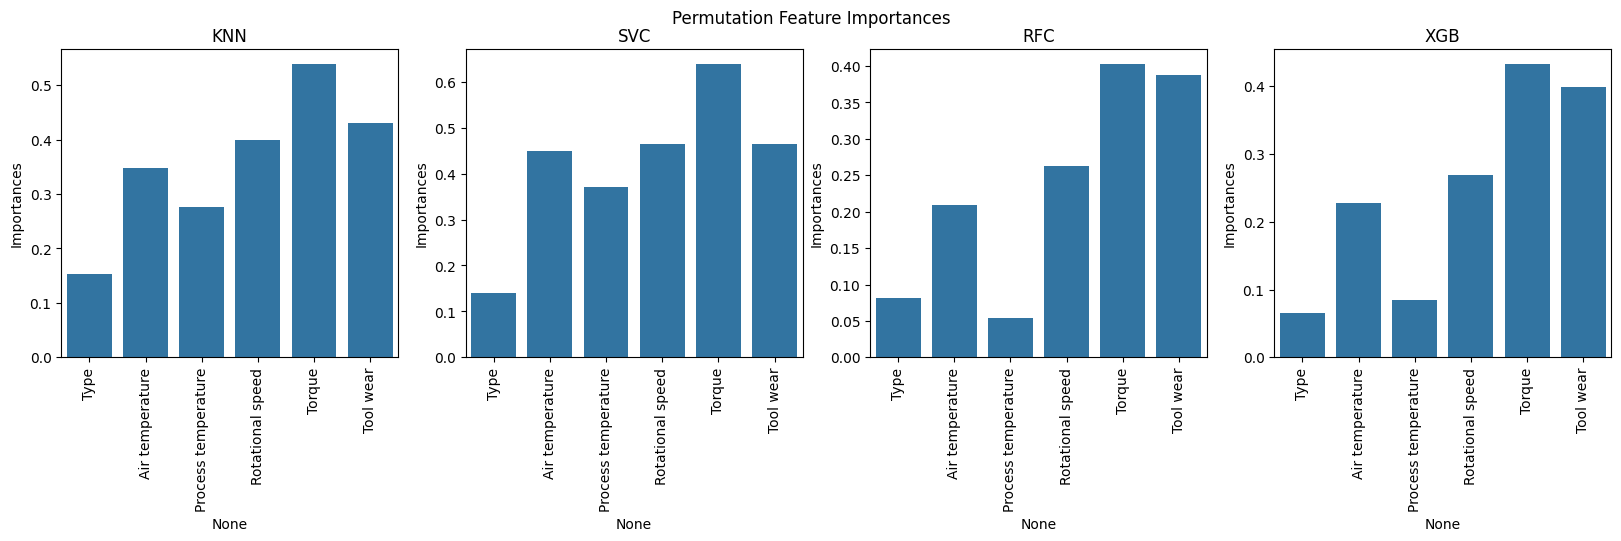

In [28]:
# Evaluate Permutation Feature Importances
f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
importances = pd.DataFrame()
for clf in fitted_models_binary:
    result = permutation_importance(clf, X_train,y_train['Target'],
                                  scoring=f2_scorer,random_state=0)
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    importances = pd.concat(objs=[importances,result_mean],axis=1)
importances.columns = clf_str

# Barplot of Feature Importances
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Permutation Feature Importances')
for j, name in enumerate(importances.columns):
    sns.barplot(ax=axs[j], x=importances.index, y=importances[name].values)
    axs[j].tick_params('x',labelrotation=90)
    axs[j].set_ylabel('Importances')
    axs[j].title.set_text(str(name))
plt.show()

Osservazioni sulle Feature importances:

Tipo è la caratteristica con il significato più basso, in accordo con quanto osservato durante l'analisi esplorativa. Tuttavia, la sua importanza rimane strettamente positiva in ciascuno dei casi considerati e quindi rimuoverla completamente avrebbe portato ad un calo delle prestazioni di previsione, non giustificato da un guadagno computazionale significativo;
A differenza della regressione logistica, i modelli testati pongono grande enfasi sull'usura degli utensili, nonché sulla coppia e sulla velocità di rotazione. Dal momento che il primo da solo è legato a una categoria specifica di guasti e distorce fortemente il kdeplot di guasto della macchina, abbiamo un segno che i nostri modelli hanno ancora funzionato bene.

Rephrase
NEW




4) MULTI-CLASS TASK
Passiamo ora al secondo compito di questo progetto, cioè prevedere non solo se ci sarà un fallimento, ma anche il tipo di fallimento che si verificherà. Quindi siamo nel caso di problemi di classificazione multiclasse che fanno presumere che ogni campione sia assegnato a una e solo un'etichetta. Questa ipotesi è verificata perché nella pre-elaborazione dei dati abbiamo rimosso tutte le osservazioni ambigue che appartenevano a più di una classe.

Per gli obiettivi multiclasse, quando calcoliamo i valori dei punteggi AUC, F1 e F2, dobbiamo impostare il parametro "media". Scegliamo "media=ponderata", per tenere conto dello squilibrio di classe: infatti, al termine della pre-elaborazione dei dati, abbiamo l'80% di macchina FUNZIONANTE e il 20% di macchine fallite. Per quanto riguarda l'attività di classificazione binaria, scegliamo la regressione logistica come modello di base e cerchiamo modelli che ottengano valori più alti per le metriche scelte. In particolare, adattiamo al caso multiclasse i modelli sviluppati nella sezione precedente. Mentre molti algoritmi di classificazione (come K-nearest neighbor, Random Forest e XGBoost) permettono naturalmente l'uso di più di due classi, alcuni (come Logistic Regression e Support Vector Machines) sono per natura algoritmi binari; questi possono, tuttavia, essere trasformati in classificatori multiclasse da una varietà di strategie. Per il nostro progetto, decidiamo di utilizzare l'approccio "OnevsRest", che prevede la formazione di un singolo classificatore per classe, con i campioni di quella classe come campioni positivi e tutti gli altri campioni come negativi. Lo scegliamo perché è computazionalmente più efficiente di altri tipi di approccio.

4.1) Benchmark di regressione logistica
Prima vediamo come si comporta la regressione logistica:

Validation set metrics:
ACC    0.926
AUC    0.983
F1     0.909
F2     0.919
dtype: float64
Test set metrics:
ACC    0.922
AUC    0.982
F1     0.904
F2     0.914
dtype: float64


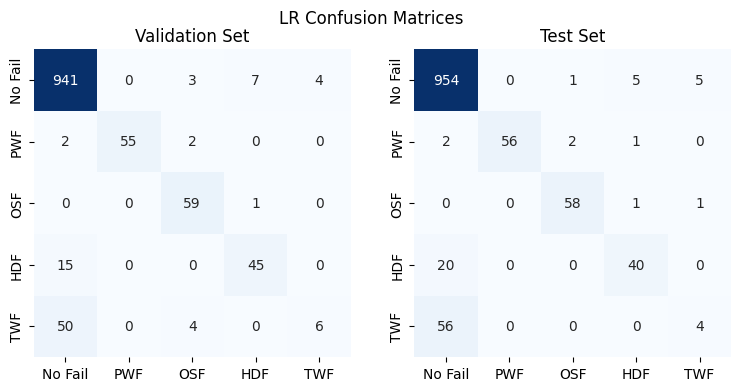

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
No Failure,1.920864,0.224090,2.866848,0.106442,0.059894,0.287084
Power Failure,0.697373,0.824558,0.982471,944.048373,2822.376842,0.744856
Tool Wear Failure,0.036806,0.215535,2.777322,0.108932,8.748803,406.189304
Overstrain Failure,0.636280,4314.687600,0.004253,0.000458,0.398540,0.711005
Heat Dissipation Failure,1.045501,1.337837,0.739732,0.225326,0.118551,749.948357


In [29]:
# multiclass classification
lr = LogisticRegression(random_state=0,multi_class='ovr')
lr.fit(X_train, y_train['Failure Type'])
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# Validation metrics
cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'multi_class')
cm_test_lr, metrics_test_lr = eval_preds(lr,X_test,y_test,y_test_lr,'multi_class')
print('Validation set metrics:',metrics_val_lr, sep='\n')
print('Test set metrics:',metrics_test_lr, sep='\n')

cm_lr = [cm_val_lr, cm_test_lr]
cm_labels = ['No Fail','PWF','OSF','HDF','TWF']
# Show Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(9,4))
fig.suptitle('LR Confusion Matrices')
for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True,
              fmt='d', cmap='Blues', cbar=False)
    axs[j].title.set_text(title)
    axs[j].set_xticklabels(cm_labels)
    axs[j].set_yticklabels(cm_labels)
plt.show()

# Odds for interpretation
odds_df = pd.DataFrame(data = np.exp(lr.coef_), columns = X_train.columns,
                       index = df_res['Failure Type'].unique())
odds_df

Nella tabella sopra ci sono, per ogni classe, le quote di Regressione Logistica che spiegano il contributo di ogni caratteristica nella previsione di appartenenza a una classe specifica. Confrontando questa tabella con la dispersione PCA e le osservazioni che abbiamo fatto, comprendiamo che c'è un accordo completo sulle caratteristiche che più influenzano il tipo di guasto. Ad esempio, se guardiamo ai valori di PWF in quote, vediamo che la velocità di rotazione e la coppia sono quelle più importanti per la previsione di appartenenza a questa classe. Nell'analisi della PCA abbiamo affermato che la PWF sembra dipendere solo dalla PC2, cioè dalla potenza che è il prodotto della velocità di rotazione e della coppia. Possiamo fare considerazioni simili per altre classi.

4.2) Modelli
Per ogni modello lanciamo la Gridsearch per l'ottimizzazione iperparametro, utilizzando come metrica per valutare il modello il punteggio medio ponderato F2. Analogamente al caso binario, la Gridsearch è stata avviata sui parametri che, guardando in letteratura, risultano essere preponderanti per ogni modello specifico e i valori di griglia da cercare sono stati definiti in base alla letteratura e a diversi test effettuati.

In [30]:
# Models
knn = KNeighborsClassifier()
svc = SVC(decision_function_shape='ovr')
rfc = RandomForestClassifier()
xgb = XGBClassifier()
clf = [knn,svc,rfc,xgb]
clf_str = ['KNN','SVC','RFC','XGB']

knn_params = {'n_neighbors':[1,3,5,8,10]}
svc_params = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}
rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}
xgb_params = {'n_estimators':[100,300,500],
              'max_depth':[5,7,10],
              'learning_rate':[0.01,0.1],
              'objective':['multi:softprob']}

params = pd.Series(data=[knn_params,svc_params,rfc_params,xgb_params],
                    index=clf)


# Tune hyperparameters with GridSearch (estimated time 8-10m)
print('GridSearch start')
fitted_models_multi = []
for model, model_name in zip(clf, clf_str):
    print('Training '+str(model_name))
    fit_model = tune_and_fit(model,X_train,y_train,params[model],'multi_class')
    fitted_models_multi.append(fit_model)

GridSearch start
Training KNN
Best params: {'n_neighbors': 1}
Training time: 0m 4s
Training SVC
Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 2m 3s
Training RFC
Best params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 0}
Training time: 3m 14s
Training XGB
Best params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'objective': 'multi:softprob'}
Training time: 3m 7s


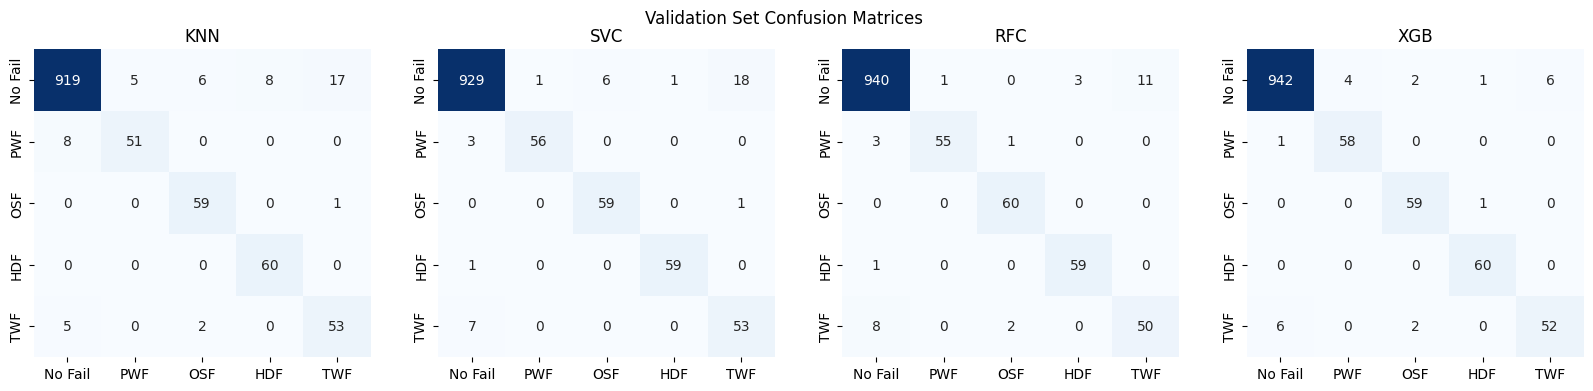

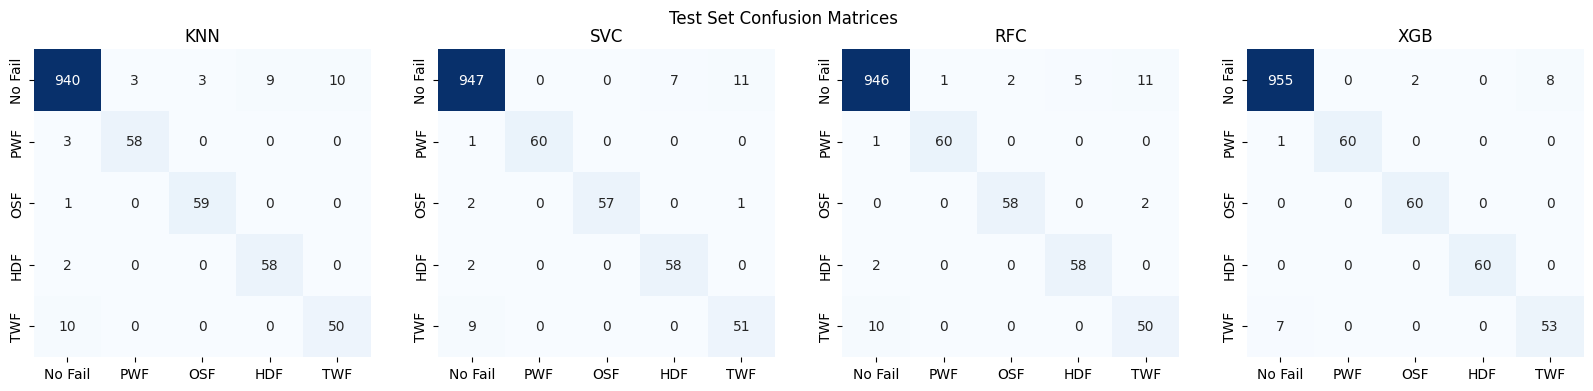


Validation scores:
       KNN    SVC    RFC    XGB
ACC  0.956  0.968  0.975  0.981
AUC  0.956  0.993  0.998  0.999
F1   0.957  0.969  0.975  0.981
F2   0.957  0.968  0.975  0.981
Test scores:
       KNN    SVC    RFC    XGB
ACC  0.966  0.973  0.972  0.985
AUC  0.956  0.995  0.997  0.999
F1   0.966  0.973  0.972  0.985
F2   0.966  0.973  0.972  0.985


In [31]:
# Create evaluation metrics

task = 'multi_class'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_multi,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_multi,X_test,y_test,clf_str,task)

# Show Validation Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Validation Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Show Test Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Print scores
print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

Confrontando i risultati ottenuti, vediamo che K-NN è il modello che esegue il peggio e la sua precisione è leggermente inferiore a quella della regressione logistica. Nonostante questo, non possiamo escluderlo a priori, in quanto raggiunge ancora valori elevati per le metriche e, inoltre, dà una risposta immediata. Così, possiamo usarlo ogni volta che abbiamo bisogno di avere un'idea rapidamente sulla situazione e, quindi applicare altri modelli quando abbiamo più tempo.

Tutti gli altri modelli hanno prestazioni migliori rispetto al benchmark e ottengono valori elevati per le metriche scelte sia per la validazione che per il set di test. Le prestazioni di SVC e RFC sono molto simili e XGB si comporta meglio di loro. Se guardiamo la fase di allenamento, SVC e RFC prendono lo stesso tempo, mentre XGB prende più di quattro volte tanto quanto loro. Quindi, dal momento che, il miglioramento ottenuto con XGB è solo 1,5%, si può scegliere quale modello preferisce in base alle sue esigenze. Mentre i migliori parametri per la multiclasse K-NN e SVC sono gli stessi della classificazione binaria, per XGB e RFC la Gridsearch per i due tipi di attività restituisce parametri diversi. Inoltre, nel passaggio dal problema binario a quello multiclasse, il tempo di formazione stimato rimane lo stesso per tutti i modelli, ad eccezione di XGB che lo triplica. Al fine di capire come le caratteristiche contribuiscono alle previsioni, diamo un'occhiata alla Permutation Feature Importances per ogni modello.

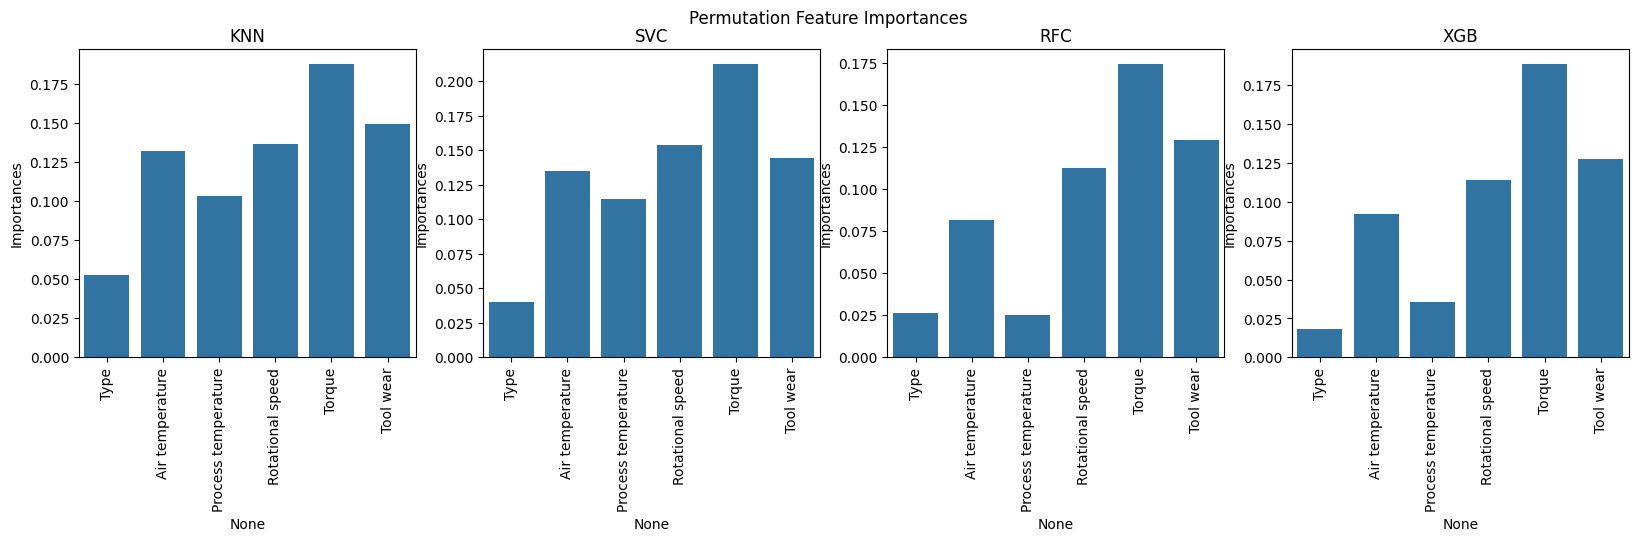

In [32]:
# Evaluate Permutation Feature Importances
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
importances = pd.DataFrame()
for clf in fitted_models_multi:
    result = permutation_importance(clf, X_train,y_train['Failure Type'],
                                  scoring=f2_scorer,random_state=0)
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    importances = pd.concat(objs=[importances,result_mean],axis=1)

importances.columns = clf_str

# Barplot of Feature Importances
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Permutation Feature Importances')
for j, name in enumerate(importances.columns):
    sns.barplot(ax=axs[j], x=importances.index, y=importances[name].values)
    axs[j].tick_params('x',labelrotation=90)
    axs[j].set_ylabel('Importances')
    axs[j].title.set_text(str(name))
plt.show()

Dai barplot precedenti vediamo che i modelli danno più importanza alla coppia, all'usura degli utensili e alla velocità di rotazione mentre il contributo del tipo è molto basso. Questo è in accordo con le osservazioni fatte nell'esplorazione del set di dati nella Sezione 1-2 ed è coerente con le Permutation Feature Importances del compito binario. K-NN è colui che dà più importanza al Tipo, ma, diversamente dal caso binario, qui vediamo che per ogni modello il contributo del Tipo è quasi zero. Quindi, testiamo il modello su un nuovo set di dati, quello vecchio da cui abbiamo rimosso la colonna Tipo. Per K-NN e SVC c c'è un miglioramento insignificante nei valori delle metriche, che erano già molto buoni. Per RFC e XGB non vediamo alcun cambiamento sui valori delle metriche. Poiché il tempo di formazione per i diversi modelli è approssimativamente uguale in entrambi i casi, permettiamo agli utenti di scegliere quale set di dati utilizzare.

5) Percorsi decisionali
Qui mostriamo i percorsi decisionali di uno degli alberi che compongono la foresta casuale per entrambi i compiti, troncati a profondità = 4. Tuttavia questa profondità è sufficiente per verificare che gli alberi richiedono di essere profondi perché i confini di decisione sono complessi e non sono troppo. Questo è evidente se si guarda all'albero multi-classe, dove alcuni tipi di fallimento non appaiono prima della profondità quattro, ma anche nell'albero di classificazione binaria guardando l'evoluzione del punteggio Gini mentre si segue la maggior parte dei percorsi. Un'ulteriore osservazione può essere fatta sulla caratteristica Tipo è il nodo di origine di entrambi i grafici e separare la classe di maggioranza (bassa qualità) dagli altri due al primo passo. Appare solo una volta in più nella parte superiore degli alberi e si mostra sporadicamente di nuovo ai piani più bassi, dove il suo impatto è scarso.

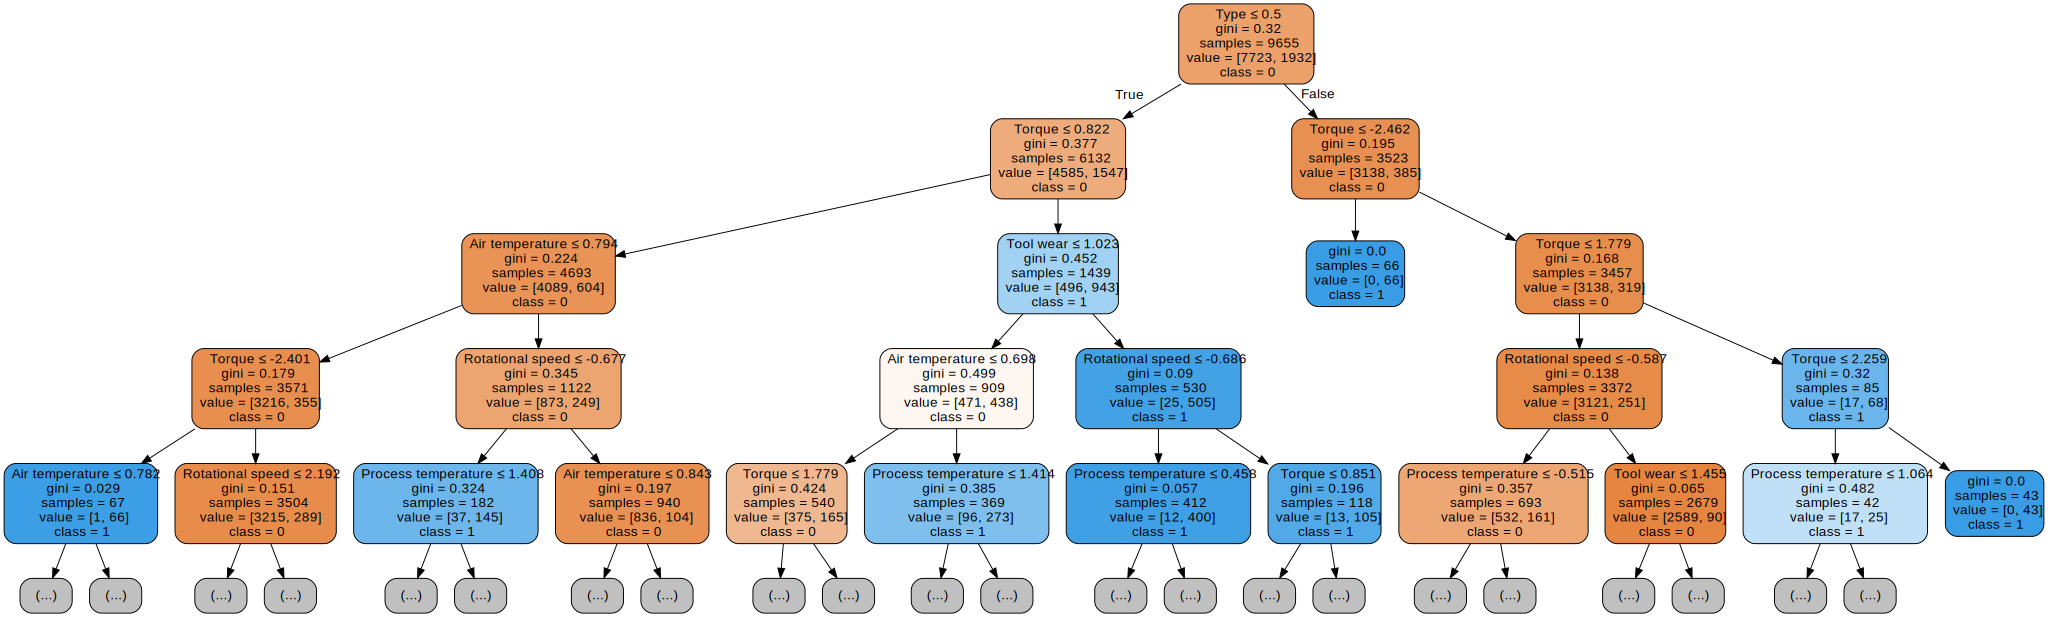

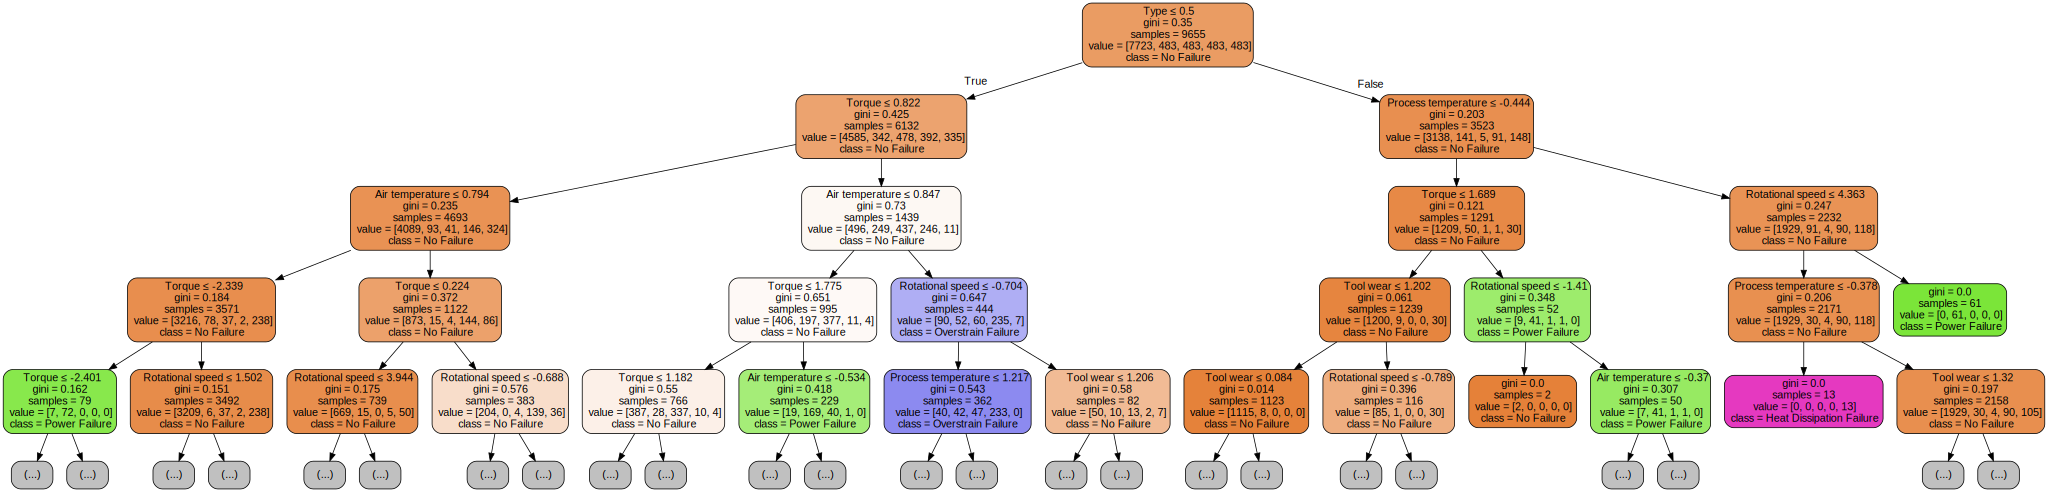

In [35]:
# Random Forest Decision Path
from sklearn import tree
import graphviz

tree_binary = fitted_models_binary[2].best_estimator_.estimators_[0]
tree_multi = fitted_models_multi[2].best_estimator_.estimators_[0]
trees = [tree_binary,tree_multi]
targets = ['Target', 'Failure Type']
for decision_tree, target in zip(trees, targets):
    decision_tree.fit(X_train,y_train[target])
    classes = list(map(str,df_res[target].unique()))

    dot_data = tree.export_graphviz(decision_tree, out_file=None,
                                  feature_names=X.columns,
                                  class_names=classes,
                                  filled=True, rounded=True,
                                  special_characters=True,
                                  max_depth=4)  # uncomment to see full tree
    graph = graphviz.Source(dot_data)
    graph.render(target+" Classification tree")
    display(graph)

6) Conclusions
According to the analyses carried out and the results obtained, it is possible to make some conclusive considerations related to this project.

We decided to tackle two tasks: predict whether a machine will fail or not and predict the type of failure that will occur. Before developing the models we did data preprocessing to ensure the validity of the assumptions of applicability of the models and ensure the best performances. Briefly, in preprocessing phase we have deleted some ambiguous samples, we applied a label encoding to the categorical columns and then we performed the scaling of the columns with StandardScaler. We also noticed the presence of some data points which at first we referred as outliers but later turned out to be part of the natural variance of the data and played an important role in the classification task. Then we ran PCA and found that most of the variance is explained by the first three components, that can be represented as the following features: combination of the two Temperatures, Machine Power (product of Rotational Speed and Torque) and Tool Wear. In according to this, we found that these are the features that contribute the most in the predictions when apply the models. Contrary to logical predictions, we demonstrated that the machine’s type does not affect the presence of failure.

At the end, we can conclude that for both task the chosen models perform very well. For both tasks the best model is XGBoost and the worst is KNN; however the response time of KNN is instant while XGBoost takes more time and this further increase when we proceed with the multi-class classification task. The choice of the model depends on the needs of the company: for faster application one can use KNN while if one cares more about accuracy one can use XGBoost.